In [1]:
%%html
<style>
div.text_cell_render{
    font-size:14pt;
}
</style>

# Lecture 11 - Full-Waveform Inversion (FWI)

To complete the trilogy of FWI lectures, we will use what we have learned in the previous sessions to implement an FWI problem in Devtio and highlight the core ideas behind the implementation of seismic inversion problems (where we create an image of the subsurface from field recorded data) in general.

## Inversion requirements

To recap, seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

Shortly we will introduce the gradient operator.

## Notes on the operators

As we have already described the creation of a forward modelling operator, we will only call a wrapper function here. This wrapper already contains all the necessary operators for seismic modeling, imaging and inversion. Operators introduced for the first time in this tutorial will be properly described.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from devito import configuration
from examples.seismic import Model
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output
from examples.seismic.acoustic.operators import (
    ForwardOperator, AdjointOperator, GradientOperator, BornOperator
)
plt.rcParams['figure.figsize'] = (12.0, 6.0)

## Computational considerations

As we will see, FWI is computationally extremely demanding. To keep this tutorial as lightweight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [3]:
nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 1000  # Number of outer FWI iterations

# True and smooth velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

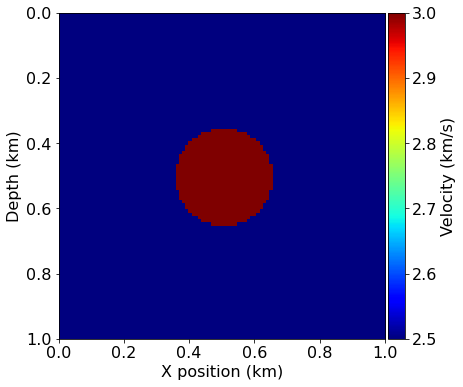

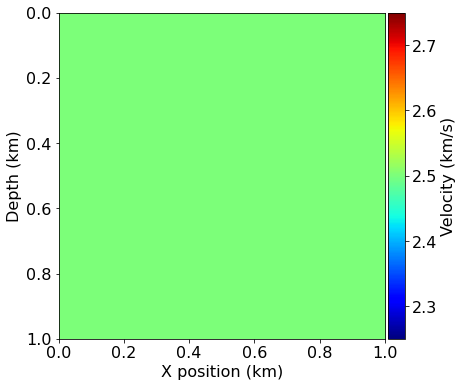

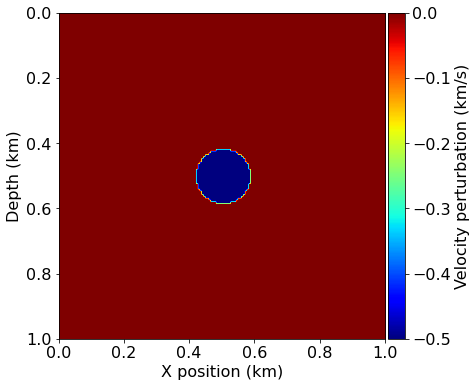

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

In this tutorial, we will use the simplest case for inversion, namely a transmission experiment. The source(s) will be located on one side of the model and the receivers on the other side. This allows most of the information necessary for inversion to be recorded, since reflections usually lead to poor inversion results.

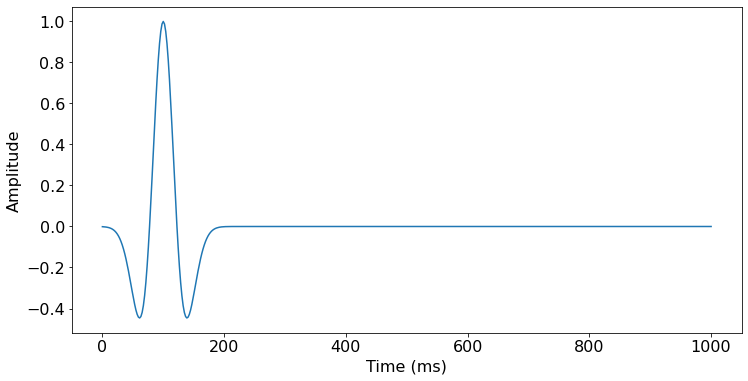

In [5]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry


t0 = 0.
tn = 1000. 
f0 = 0.010
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# src_coordinates[0, 0] = np.array(model.domain_size[0]) * .5
# src_coordinates[0, 1] = 980.

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
# rec_coordinates[:, 0] = 980.
# rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 20.
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[1], num=nreceivers)
# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

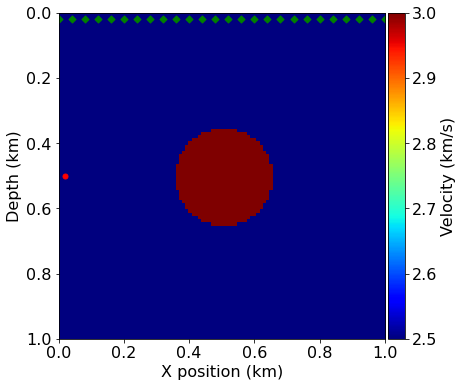

In [6]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

# Full-Waveform Inversion

As we noted previously, our inversion frame work will be based on solving the following boundary value problem for the second order acoustic wave-equation:

\begin{align*}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\nabla^2 u = s, \\
  u(\mathbf{x},0)=0, \\
  \frac{\partial u}{\partial t}(\mathbf{x},0)=0.
\label{eq:we0} \tag{1}
\end{align*}

The wave equation represents a linear relationship between a wavefield $u$ and the source $s$ that generates the wavefield. After discretisation (with for example finite differences) we can therefore write $\eqref{eq:we0}$ as a matrix equation

\begin{equation}
  \mathbf{A}\mathbf{u}=\mathbf{s},
\label{eq:we1} \tag{2}
\end{equation}

where $\mathbf{u}$ and $\mathbf{s}$ are column vectors that represent the source and wavefield at discrete points
in space and time, and $\mathbf{A}$ is a matrix that represents the discrete numerical implementation of the operator

\begin{equation}
  \frac{1}{c^2}\frac{\partial^2}{\partial t^2}-\nabla^2.
\label{eq:we3} \tag{3}
\end{equation}

Although the wave equation represents a linear relationship between $u$ and $s$, it also represents a non-linear relationship between a model $\mathbf{m}$ and wavefield $\mathbf{u}$. Thus we can also write the wave equation as

\begin{equation}
  G(\mathbf{m})=\mathbf{u}.
\label{eq:we4} \tag{4}
\end{equation}

Here $\mathbf{m}$ is a column vector that contains the model parameters. Commonly these will be the values of $c$ at every point in the model, but they may be any set of parameters that is sufficient to describe the model, for example squared slownesses $1/c^2$. Note that in equation $\eqref{eq:we4}$ $G$ is not a matrix; it is a (non-linear) function that describes how to calculate a wavefield $\mathbf{u}$ given a model $\mathbf{m}$.

Note that the form of matrix $\mathbf{A}$ depends upon both the model properties and the details of the numerical implementation, and that the form of the function $G$ depends upon the source and the acquisition geometry. The form of $\mathbf{A}$ does not depend upon the source and the form of $G$ does not depend upon the model.

It is common in FWI to construct the numerical wave equation in $\eqref{eq:we1}$ such that the matrix
$\mathbf{A}$ represents a wave travelling forward in time, and its transpose represents a wave travelling
backwards in time. This is not essential, but it is often straightforward to achieve, in which
case it simplifies the numerics of FWI.

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [7]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [8]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

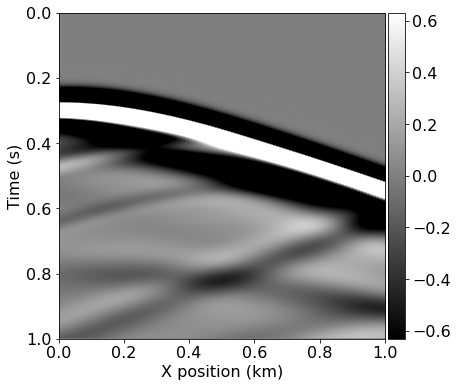

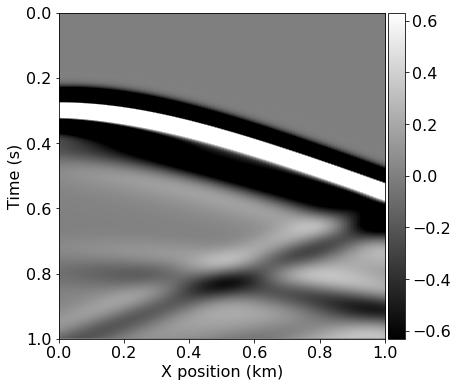

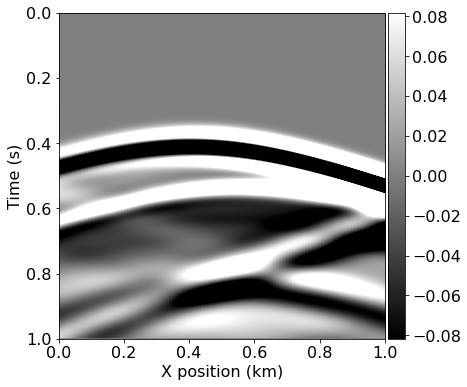

In [9]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the discrete wave velocity, $\mathbf{c}$, or equivalently the squared slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given set of measurements of the pressure wavefield $\mathbf{u}$. This can be expressed as the following optimization problem [1, 2]:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver locations, $\mathbf{P}_s^T$ is the injection operator at the source locations, $\mathbf{A}(\mathbf{m})$ is the operator representing the discretized wave equation matrix, $\mathbf{u}$ is the discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the corresponding pressure source and $\mathbf{d}$ is the measured data. It is worth noting that $\mathbf{m}$ is the unknown in this formulation and that multiple implementations of the wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. 

Although we didn't phrase it in this manner, we have already created a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the first tutorial, including appropriate implementations of the sampling operator $\mathbf{P}_r$ and source term $\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

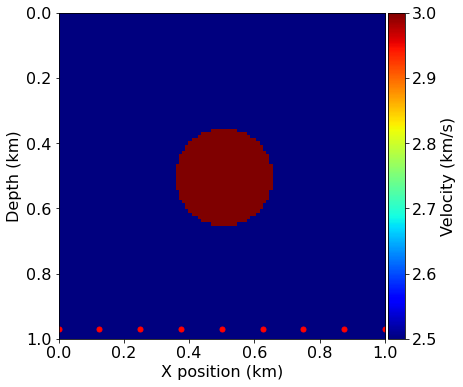

In [10]:
#NBVAL_IGNORE_OUTPUT
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 1] = 970.
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [11]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [12]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)

    objective = 0.
    #num = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)

        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)

        objective += .5* norm(residual)**2

        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
 
        
        
    return objective, grad

## Model updates

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [13]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
# assert np.isclose(ff, 57283, rtol=1e0)
# print(ff)

In [14]:
vp = model.vp.copy()

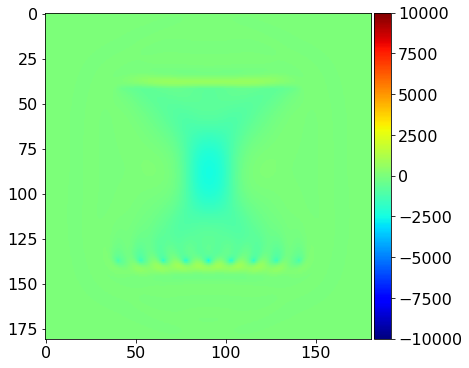

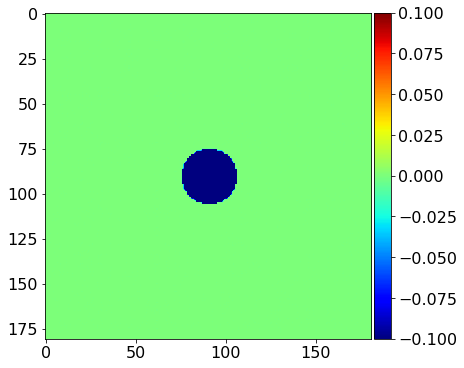

[[9.17236773e-12 4.31038226e-11 1.14064799e-10 ... 1.66667416e-10
  6.25753963e-11 1.32593684e-11]
 [4.29443495e-11 2.00516451e-10 5.25654964e-10 ... 7.69010022e-10
  2.91391716e-10 6.21315915e-11]
 [1.13214764e-10 5.23590671e-10 1.35331069e-09 ... 1.98472216e-09
  7.62613750e-10 1.64142977e-10]
 ...
 [1.08280954e-10 5.01899244e-10 1.30211508e-09 ... 1.90284943e-09
  7.27560678e-10 1.56128110e-10]
 [4.09487340e-11 1.91607022e-10 5.04076669e-10 ... 7.34181493e-10
  2.76877576e-10 5.88657595e-11]
 [8.73008350e-12 4.11108057e-11 1.09163810e-10 ... 1.58712141e-10
  5.93126728e-11 1.25322903e-11]]
80609.46


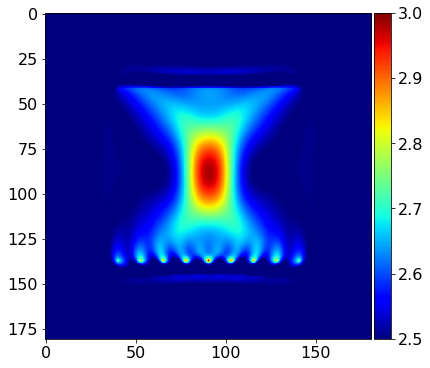

In [15]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")
print(update.data)
# Show what the update does to the model
alpha = .5 / mmax(update)
print(norm(update))
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

### Steepest/Gradient Descent

In previous lectures you would have seen minimization methods making use of the full Hessian. If the number of model parameters $n$ is large, calculating the Hessian is a major
undertaking, and inverting it is not normally computationally feasible. Consequently the
method that is typically used is to replace the inverse of the Hessian by a
simple scalar $\alpha$; this scalar is called the step length. We now have

\begin{equation}
  \delta\mathbf{m} = -\alpha\nabla\Phi_s(\mathbf{m}).
  \tag{5}
\end{equation}

The method that uses this approach is called the method of *steepest descent*, and in its
simplest form it consists of the following steps:
1. start from a model $\mathbf{m}_0$,
2. evaluate the gradient of the objective function, $\nabla_{\mathbf{m}}f$, for the current model ($f$ is what we've called $\Phi_s(\mathbf{m})$ above),
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model to obtain a new model,
5. iterate from step 2 using the new model until the objective function is sufficiently small (or we run out of patience).

To implement this, we need a method of calculating the local gradient.

In [16]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [17]:
def update(vp, alpha, dm):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    
    update = vp + alpha * dm
    update_eq = Eq(vp, update)
    Operator(update_eq)()

In [18]:
model.space_order

2

In [19]:
def line_search(x, p, phi, initial_slope, alpha=1e-4, max_search_iter=100):
    """Simple line search that halves lambda until the Armijo rule is satisfied
    
    x - initial point (at lambda=0)
    p - search direction, search is along x+lambda*p
    f - (callback) function to minimize
    initial_slope - derivative of f in x in p-direction"""
    lamda = 1/ 2.
    
    # grad = Function(name="grad", grid=model.grid)  
    
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)

    temp_model = Model(vp= x.copy(), origin=origin, shape=shape, spacing=spacing, nbl=40,
                    space_order=model.space_order, grid = model.grid)
           
    if initial_slope==0.0:
        return 1.0, 0
    for j in range(max_search_iter):
        temp_model.vp = x.copy()
        
        update(temp_model.vp, alpha, direction)
        update(temp_model.vp, -alpha, direction)
        
        # update_with_box(model0.vp, lamda, direction)
        
        # print(residual.data, d_obs.data, d_syn.data)
        
        objective = 0.
        for i in range(nshots):
             # Update source location
            geometry.src_positions[0, :] = source_locations[i, :]
        
        #print(d_obs.data)
        # Generate synthetic data from true model
            _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        #print("--------------------------------------------------------------------")
        #print(d_obs.data)
        
        # Compute smooth data and full forward wavefield u0
            _, u0, _ = solver.forward(vp= temp_model.vp, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
            compute_residual(residual, d_obs, d_syn)
        # print("u0:" , u0.data.shape)
            objective += .5* norm(residual)**2
            # solver.gradient(rec=residual, u=u0, vp=temp_model.vp, grad=grad)
        
        print(j)
        # check Armijo rule:
        if objective - phi <= alpha*lamda*initial_slope: # and abs(objective - phi) < 0.2 * phi:
            print("objective after line search {0:f},  with {1:} reductions, alpha = {2:f}".format(objective, j, lamda))
            break
        # uncomment to follow convergence of line search:
        # print(j,lamda,objective - phi, alpha*lamda*initial_slope)
        lamda /= 2.
        
        # Create placeholders for the data residual and data
        residual.data[...] = 0
        d_obs.data[...] = 0
        d_syn.data[...] = 0
    else:
        raise Exception("Line search did not converge")
    return lamda, j, objective

In [20]:
#NBVAL_SKIP

from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
i = 0
phi = 1000
# for i in range(0, fwi_iterations):
while (phi > 1):
    i = i + 1
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    temp = model0.vp.data
    
    # Store the history of the functional values
    history[i] = phi
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    # alpha = .05 / mmax(direction)
    # temp1 = model0.vp.data
    #print(np.all(temp == temp1))
    
    #print(norm(direction))
    alpha, reductions, phi= line_search(model0.vp, direction, phi, norm(direction))
    # temp2 = model0.vp.data
    #print(np.all(temp == temp2))
    # print("objective after line search {0:f},  with {1:} reductions, alpha = {2:f}".format(phi, reductions, alpha))
    
    # Update the model estimate and enforce minimum/maximum values
    # update_with_box(model0.vp, alpha , direction)
    # phi, direction = fwi_gradient(model0.vp)
    # print(norm(direction))
    # update(model0.vp, alpha, direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i))

0
objective after line search 39191.668392,  with 0 reductions, alpha = 0.500000
Objective value is 39191.668392 at iteration 1
0
objective after line search 39191.668392,  with 0 reductions, alpha = 0.500000
Objective value is 39191.668392 at iteration 2
0
objective after line search 39191.668392,  with 0 reductions, alpha = 0.500000
Objective value is 39191.668392 at iteration 3


KeyboardInterrupt: 

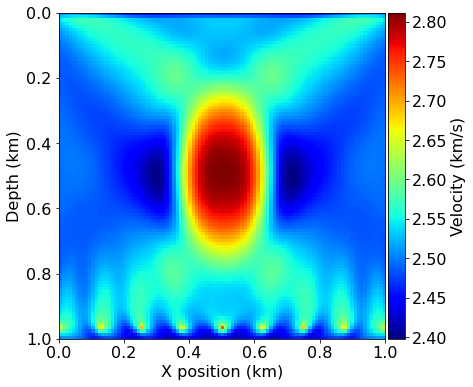

In [27]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)

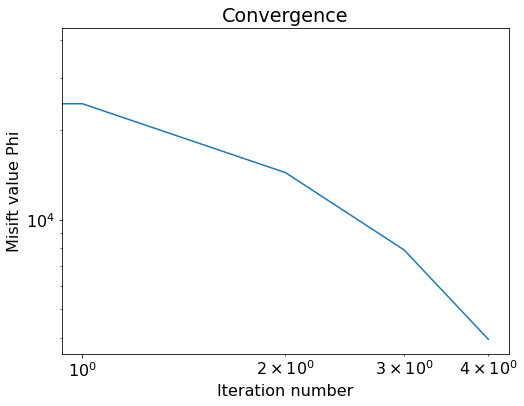

In [17]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

Finally lets review the paper entitled 'Anisotropic 3D full-waveform inversion' (located in the `related_research_papers` folder) to discuss some of the issues surrounding performing FWI on real field data. **Note that you should read this paper carefully in your own time**.

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._

## Coursework preparation

- Play around with the above algorithm and make sure you understand the workflow!
- How do, e.g., the following affect the final result:
- Changing the number of iterations?
- Making the grid finer?
- Increasing the number of sources and receivers?
- Positioning the sources and receivers differently?

What other changes can you make to improve the result?